In [1]:
!pip install keras_tuner

In [1]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

In [2]:
os.getenv('HOME')

'/aiffel'

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

## 라벨링 확인

In [5]:
label_id = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 
         5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]


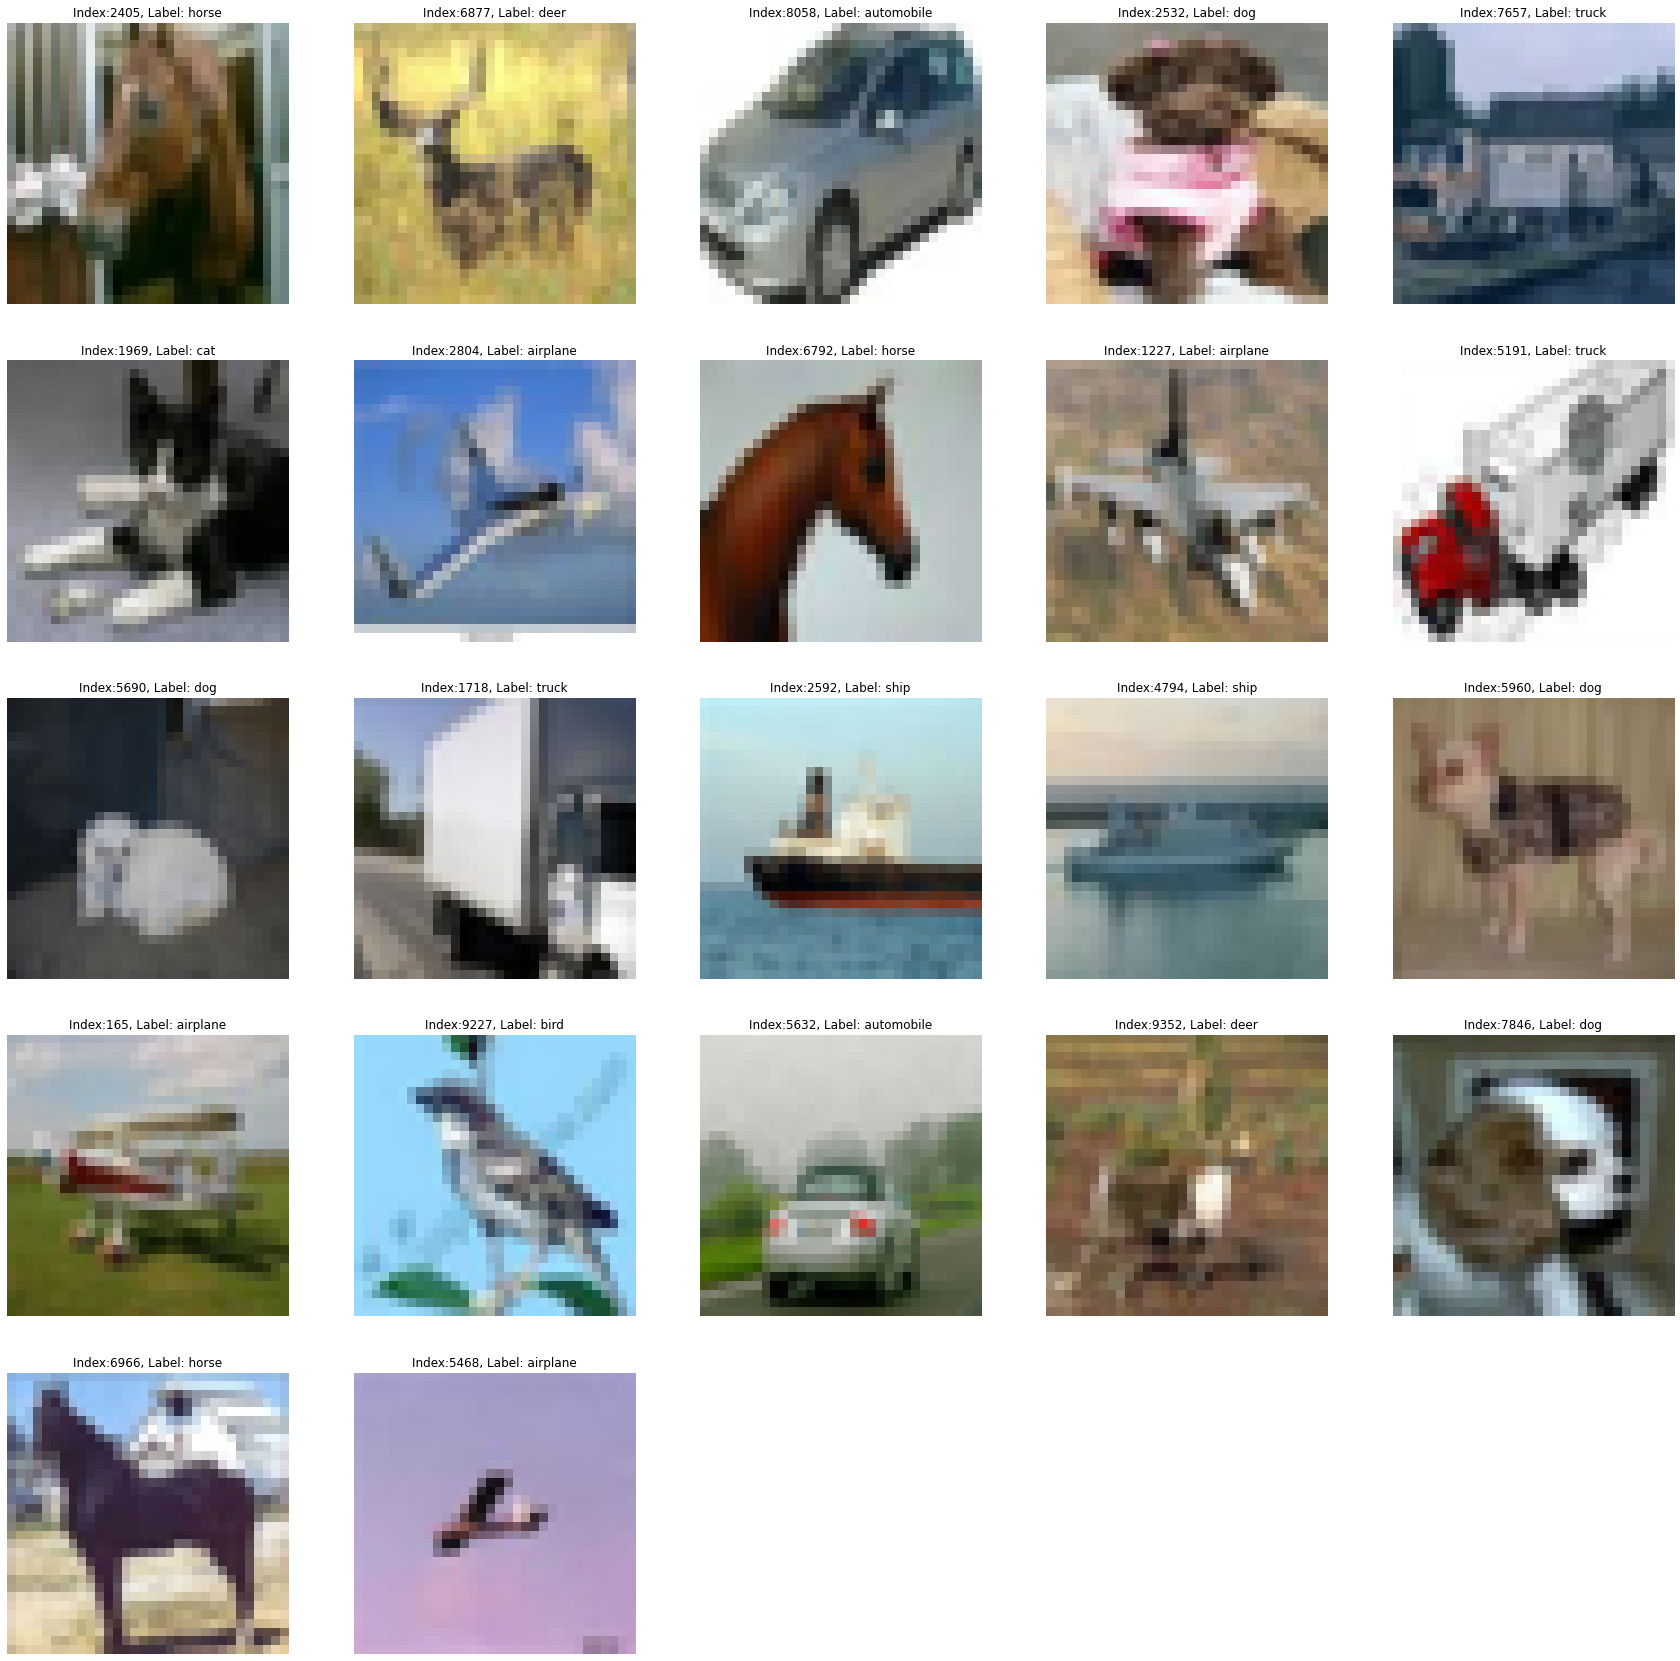

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(30, 30))
c_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, idx in enumerate(label_id):
    img = x_train[idx]
    label = y_train[idx][0]  # 배열에서 첫 번째 값을 가져와 스칼라 정수로 변환
    
    if label < len(c_name):
        plt.subplot(5, 5, i + 1)  # 5x5 그리드에 이미지를 배치합니다.
        plt.imshow(img)
        plt.title(f"Index:{idx}, Label: {c_name[label]}")
        plt.axis('off')
    else:
        print(f"Label value {label} is out of range for c_name list.")

plt.show()

라벨이 잘 입력된것을 확인함

In [7]:
X_train = x_train.reshape(-1,32,32,3)
X_test = x_test.reshape(-1,32,32,3)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)

(40000, 32, 32, 3)


In [9]:
class DeepTuner(kt.Tuner):
    def fun_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice('batch_size',[16,32]), **fit_kwargs)

        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(model.metrics_names, eval_scores)}

In [10]:


def build_model(hp):
    # Input layer
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(32, 32, 3), name='inputs'))
    
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(hp.Int('conv_units_1', min_value=32, max_value=128, step=5), (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2D(hp.Int('conv_units_2', min_value=32, max_value=128, step=5), (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    # Flatten layer
    model.add(tf.keras.layers.Flatten())

    # Fully connected layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'dense_units_{i}', values=[32, 64, 128, 256]), activation='relu'))

    # Output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax', name='outputs'))
    
    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=5,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 5 Complete [00h 00m 16s]
accuracy: 0.7218000292778015

Best accuracy So Far: 0.7425249814987183
Total elapsed time: 00h 02m 03s


In [12]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 52)        1456      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 52)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 52)        208       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 127)       59563     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 127)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 127)         508       
_________________________________________________________________
flatten_1 (Flatten)          (None, 4572)             

In [14]:
pwd

'/aiffel/aiffel/aiffel_quest/mini_quest_240409'

In [13]:
model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4230 - accuracy: 0.5124
Epoch 2/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9508 - accuracy: 0.6643
Epoch 3/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7244 - accuracy: 0.7436
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5471 - accuracy: 0.8076
Epoch 5/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3882 - accuracy: 0.8617


In [15]:
save_path = os.getenv('HOME') + '/aiffel/aiffel_quest/mini_quest_240409'
fname= os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/aiffel_quest/mini_quest_240409/model/assets


![nn](rubric.png)
![nn](model.png)

# 회고
- 아직까지 모델층 생성을 함수로 만들기에는 실력이 많이 부족핟는 것을 느낀다. 계속해서 코딩 공부를 해야겠다.
- 여담이지만 처음에 데이터로드릃 할때 100을 불러와서 시간을 많이 허비했다.
- 그리고 docker serving에 실패해서 조금 아쉽다.